# prep

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

import scipy.io as sio
from tqdm import tqdm
from IPython.display import clear_output

import os
import pickle

%load_ext autoreload
%autoreload 2

In [2]:
local_flag = False
if local_flag:
    repo_dir = r'D:\repo\inter_data\inter'.replace("\\", "/") # under env dimred
else:
    repo_dir = r'C:\Users\ll357\Documents\inter'.replace("\\", "/")
os.chdir(repo_dir)
from src import adp

In [3]:
dir_inter = r'Z:\All_Staff\home\lan\Data\2P_images\mat_inter/'.replace('\\', '/')
dir_file = os.path.join(dir_inter, 'adp_dataset_master.xlsx')
data_info = pd.read_excel(dir_file)
data_info.head()

meta = data_info[(data_info.paradigm == 'grating_lindsey_miaomiao')]
# meta = data_info[(data_info.paradigm == 'grating') 
                #  & (data_info.area == 'LM')
                #  & ((data_info.cellpose_seg == True) | (data_info.manual_seg == True))] # ensure segmentation
meta = meta.reset_index(drop=True)
nset = meta.shape[0]
print(meta.area.value_counts(), nset)

meta

V1    12
Name: area, dtype: int64 12


,mouse,date,area,depth,num,cellpose_seg,manual_seg,paradigm,gcamp,AWS,note
0,674,170324,V1,NaN,002-003,NaN,True,grating_lindsey_miaomiao,6f,NaN,TC and input already concat-ed 002-003. see in...
1,689,170323,V1,NaN,002-003,NaN,True,grating_lindsey_miaomiao,6f,NaN,NaN
2,696,170323,V1,NaN,002-003,NaN,True,grating_lindsey_miaomiao,6s,NaN,NaN
3,684,170327,V1,NaN,002-003,NaN,True,grating_lindsey_miaomiao,6f,NaN,NaN
4,711,170503,V1,NaN,002-003,NaN,True,grating_lindsey_miaomiao,6s,NaN,NaN
5,712,170503,V1,NaN,002-003,NaN,True,grating_lindsey_miaomiao,6s,NaN,NaN
6,574,170510,V1,NaN,002-003,NaN,True,grating_lindsey_miaomiao,6s,NaN,NaN
7,720,170808,V1,NaN,002-003,NaN,True,grating_lindsey_miaomiao,6s,NaN,NaN
8,738,170810,V1,NaN,002-003,NaN,True,grating_lindsey_miaomiao,6f,NaN,NaN
9,739,170811,V1,NaN,002-003,NaN,True,grating_lindsey_miaomiao,6f,NaN,NaN


# batch write df_tidy

In [16]:
nset = len(meta)

for iset in tqdm(range(nset)):
    print(f'iset={iset}, nset={nset}')


    ## load data
    mouse = meta.loc[iset, 'mouse'].astype(str)
    imouse = 'i' + mouse
    date = meta.loc[iset, 'date'].astype(str)
    area = meta.loc[iset, 'area']
    # sess = '00' + meta.loc[iset, 'num'].astype(str)
    sess = meta.loc[iset, 'num']
    print(mouse, date, area, sess)
    dir_identifier = f'{area}_{imouse}_{date}_{sess}'

    mat_inter = r'\\duhs-user-nc1.dhe.duke.edu\dusom_glickfeldlab\All_Staff\home\lan\Data\2P_images\mat_inter/'.replace('\\', '/')
    for dirname in os.listdir(mat_inter):
        if dir_identifier in dirname:
            dir_data = mat_inter + dirname
            break

    stim_id, resp_ad, resp_tg = adp.load_resp_trial(os.path.join(dir_data), vis_filter=False) # already sliced by resp time window from matlab. only differentiating isi in resp_tg by indexing into trial. match isi_nframe
    ## NOTE: stim_id contains the final trial, which should be cut off due to incomplete trial, to match trace_by_trial


    ## construct dfof
    R1_dfof = resp_ad.flatten() # cell x trial, row major flatten
    R2_dfof = resp_tg.flatten()
    dfof = np.hstack((R1_dfof, R2_dfof)) # sort by cell_id, then trial_id, finally resp_id


    ## construct cell, trial, resp id
    ncell = resp_ad.shape[0]
    ntrial = resp_ad.shape[1]
    cell_id = np.repeat(np.arange(ncell), ntrial) # repeat cell id arr for ntrial times == sort by cell_id, then trial_id
    cell_id = np.hstack((cell_id, cell_id)) # stack two copies for R1 and R2. finally sort by resp_id

    trial_id = np.tile(np.arange(ntrial), ncell) # for each cell, go over all trials
    trial_id = np.hstack((trial_id, trial_id))

    len_df = ncell * ntrial * 2 # 2 for (R1, R2)
    resp_id = ['R1'] * int(len_df/2) + ['R2'] * int(len_df/2) # first half is flattened resp_ad, second half is flattened resp_tg


    ## construct stim info col: stim 2 orientation, stim 1 orien, isi, adapter contrast
    trial_stim_orien = [item[0] for item in stim_id['stim_ori']] # print(np.sort(np.unique(trial_stim_orien)))
    trial_stim_orien_dict = {} ## map stim2 orientation to int. convert from grat ori in deg to 0-based indexing (ensured)
    print(np.sort(np.unique(trial_stim_orien)))
    assert len(np.unique(trial_stim_orien)) == 8 # ensure 8 ori
    assert min(np.unique(trial_stim_orien)) == 0
    assert max(np.unique(trial_stim_orien)) == 180-22.5
    for i, item in enumerate(np.sort(np.unique(trial_stim_orien))):
        trial_stim_orien_dict[item] = i
    trial_stim_orien_int = [trial_stim_orien_dict[item] for item in trial_stim_orien]

    trial_isi_nframe = [item[0] for item in stim_id['isi_nframe']]
    trial_adapter_contrast = [item[0] for item in stim_id['adapter_contrast']]

    trial_stim_orien_int = trial_stim_orien_int[:ntrial] # if any stim info longer than ntrial, slice off the last one
    trial_isi_nframe = trial_isi_nframe[:ntrial]
    trial_adapter_contrast = trial_adapter_contrast[:ntrial]
    

    ## make stim info col: same as trial_id - tile then hstack
    stim_id_col = np.tile(trial_stim_orien_int, ncell)
    isi_col = np.tile(trial_isi_nframe, ncell)
    ad_con_col = np.tile(trial_adapter_contrast, ncell)

    stim_id_col = np.hstack((stim_id_col, stim_id_col)) # stim2 orientation
    isi_col = np.hstack((isi_col, isi_col))
    ad_con_col = np.hstack((ad_con_col, ad_con_col))

    df_tidy = pd.DataFrame({'dfof': dfof, 'cell_id': cell_id, 'trial_id': trial_id, 'resp_id': resp_id, 
                            'isi': isi_col, 'stim1_contrast': ad_con_col, 
                            'stim2_id': stim_id_col,})
    df_tidy['area'] = area
    df_tidy['stim1_id'] = 0 # adapter (stim1) is always 0 deg / vertical gratings
    df_tidy.loc[(df_tidy.stim1_contrast == 0) & (df_tidy.resp_id == 'R1'), 'dfof'] = np.nan # set R1 to nan if no adapter (stim1_contrast == 0)
    df_tidy = df_tidy.dropna().reset_index(drop=True) # drop nan rows

    print(df_tidy.isi.unique()) # ensure isi 250 and 750
    assert min(df_tidy.isi.unique()) == 8
    assert max(df_tidy.isi.unique()) == 23
    df_tidy['isi'] = df_tidy['isi'].apply(lambda x: 250 if x <= 10 else 750) # convert isi_nframe to ms. 250 ms is about 8 frames, 750 ms is about 22-23 frames
    df_tidy.loc[df_tidy.stim1_contrast == 0, 'isi'] = 6000 # set ISI to 6000 ms (equal to ITI) if no adapter (stim1_contrast == 0)


    ## vis cell filter, well_fit filter, & img driven cell-stim filter
    df_tidy['filter_cell_vis'] = np.nan
    # df_tidy['filter_cell_well_fit'] = np.nan
    df_tidy['filter_cell_stim'] = np.nan

    with open(os.path.join(dir_data, 'vis_driven_ttest_bonferroni.pickle'), 'rb') as f: # using new vis driven filter
        filter_file = pickle.load(f)
    filter_cell_stim = filter_file['img_driven']
    filter_cell_vis = filter_file['vis_driven']

    # well_fit = sio.loadmat(os.path.join(dir_data, 'fit_bootstrap_90perc.mat'))
    # well_fit_cell = np.array([x[0] for x in well_fit['well_fit_cell']])

    for icell in np.arange(filter_cell_stim.shape[0]): # filter_cell_stim is ncell x nstim
        df_tidy.loc[df_tidy['cell_id']==icell, 'filter_cell_vis'] = filter_cell_vis[icell]
        # df_tidy.loc[df_tidy['cell_id']==icell, 'filter_cell_well_fit'] = well_fit_cell[icell]
        for istim in np.arange(filter_cell_stim.shape[1]):
            df_tidy.loc[(df_tidy['stim2_id']==istim) & (df_tidy['cell_id']==icell), 'filter_cell_stim'] = filter_cell_stim[icell, istim]
    # df_tidy.filter_cell_vis.value_counts(), df_tidy.filter_cell_stim.value_counts()


    # ## cell tuning in 3 possible ISI, 2 runs (each run uses half of the trials)
    # fit_tuning_half = sio.loadmat(os.path.join(dir_data, 'fit_tuning_half_trials.mat'))
    # ori_pref_run1 = fit_tuning_half['ori_pref_runs'][:, :, 0] # ncell x 3isi x 2run, [noad vs ad750 vs ad250]
    # ori_pref_run2 = fit_tuning_half['ori_pref_runs'][:, :, 1]

    # ori_pref_runs_sorted = well_fit['ori_pref_runs']
    # # ori_pref_runs_sorted = np.array([np.sort(x) for x in well_fit['ori_pref_runs']]) # ncell x nrun. sort each row of ori_pref_runs
    # # for icell in np.arange(10):
    # #     plt.plot(ori_pref_runs_sorted[icell, :])

    # percentile_threshold = 0.9
    # # if area == 'LI':
    # #     percentile_threshold = 0.7 # taken from well_fit_cell_criteria(_relax).m, only relax for LI
    # nrun = ori_pref_runs_sorted.shape[1]
    # rand_idx = np.random.randint(nrun*(1-percentile_threshold), nrun*percentile_threshold, size=2) # # bc well_fit cells are defined as: 90% of bootstrapped ori_pref within 22.5 deg, randomly select 2 indices between 100-900 in ori_pref_runs_sorted
    # ori_pref_noad1 = ori_pref_runs_sorted[:, rand_idx[0]] # ncell x 1
    # ori_pref_noad2 = ori_pref_runs_sorted[:, rand_idx[1]]


    # ## goodness of fit (R square) in isi 250 or 750
    # fit_tuning = sio.loadmat(os.path.join(dir_data, 'fit_tuning_isi3.mat')) # fit_tuning['fit_param'].shape # ncell x nparam x nstim
    # R_square = fit_tuning['fit_param'][:, -1, :] # ncell x nstim, final param is R_square of fit
    # R_square_750 = R_square[:, 1] # use R_sq to determine well_fit_ad
    # R_square_250 = R_square[:, 2]
    # well_fit_ad_250 = R_square_250 >= np.percentile(R_square_250, 50) # ncell x 1. only take top 50% of R_sq
    # well_fit_ad_750 = R_square_750 >= np.percentile(R_square_750, 50)


    # ## write cell property to df_tidy
    # ncell = df_tidy.cell_id.unique().shape[0]
    # for icell in np.arange(ncell):
    #     df_tidy.loc[(df_tidy.cell_id == icell), 'ori_pref_noad'] = ori_pref_run1[icell, 0] # ori_pref_run1 is ncell x 3isi, [noad vs ad750 vs ad250]
    #     df_tidy.loc[(df_tidy.cell_id == icell), 'ori_pref_ad_750'] = ori_pref_run1[icell, 1]
    #     df_tidy.loc[(df_tidy.cell_id == icell), 'ori_pref_ad_250'] = ori_pref_run1[icell, 2]

    #     df_tidy.loc[(df_tidy.cell_id == icell), 'ori_pref_noad1'] = ori_pref_run1[icell, 0] # for control plot. ori_pref_noad1 is same as ori_pref_noad
    #     df_tidy.loc[(df_tidy.cell_id == icell), 'ori_pref_noad2'] = ori_pref_run2[icell, 0] # take from another run

    #     df_tidy.loc[df_tidy['cell_id']==icell, 'filter_cell_well_fit_ad_250'] = well_fit_ad_250[icell]
    #     df_tidy.loc[df_tidy['cell_id']==icell, 'filter_cell_well_fit_ad_750'] = well_fit_ad_750[icell]
    
    # break

    ## save df_tidy as csv
    df_tidy.to_csv(os.path.join(dir_data, 'df_tidy_jin_data.csv'), index=False)

# clear_output()

  0%|          | 0/12 [00:00<?, ?it/s]

iset=0, nset=12
674 170324 V1 002-003
ncell: 73, nstim: 8, ntrial: 437
[  0.   22.5  45.   67.5  90.  112.5 135.  157.5]
[23  8]


  8%|▊         | 1/12 [00:01<00:15,  1.42s/it]

iset=1, nset=12
689 170323 V1 002-003
ncell: 19, nstim: 8, ntrial: 437
[  0.   22.5  45.   67.5  90.  112.5 135.  157.5]
[23  8]


 17%|█▋        | 2/12 [00:01<00:08,  1.19it/s]

iset=2, nset=12
696 170323 V1 002-003
ncell: 73, nstim: 8, ntrial: 394
[  0.   22.5  45.   67.5  90.  112.5 135.  157.5]
[ 8 23]


 25%|██▌       | 3/12 [00:03<00:09,  1.05s/it]

iset=3, nset=12
684 170327 V1 002-003
ncell: 31, nstim: 8, ntrial: 386
[  0.   22.5  45.   67.5  90.  112.5 135.  157.5]
[ 8 23]


 33%|███▎      | 4/12 [00:03<00:07,  1.12it/s]

iset=4, nset=12
711 170503 V1 002-003
ncell: 33, nstim: 8, ntrial: 436
[  0.   22.5  45.   67.5  90.  112.5 135.  157.5]
[ 8 23]


 42%|████▏     | 5/12 [00:04<00:05,  1.24it/s]

iset=5, nset=12
712 170503 V1 002-003
ncell: 43, nstim: 8, ntrial: 437
[  0.   22.5  45.   67.5  90.  112.5 135.  157.5]
[23  8]


 50%|█████     | 6/12 [00:05<00:04,  1.22it/s]

iset=6, nset=12
574 170510 V1 002-003
ncell: 94, nstim: 8, ntrial: 336
[  0.   22.5  45.   67.5  90.  112.5 135.  157.5]
[ 8 23]


 58%|█████▊    | 7/12 [00:06<00:05,  1.03s/it]

iset=7, nset=12
720 170808 V1 002-003
ncell: 55, nstim: 8, ntrial: 436
[  0.   22.5  45.   67.5  90.  112.5 135.  157.5]
[23  8]


 67%|██████▋   | 8/12 [00:07<00:04,  1.04s/it]

iset=8, nset=12
738 170810 V1 002-003
ncell: 16, nstim: 8, ntrial: 396
[  0.   22.5  45.   67.5  90.  112.5 135.  157.5]
[23  8]


 75%|███████▌  | 9/12 [00:08<00:02,  1.21it/s]

iset=9, nset=12
739 170811 V1 002-003
ncell: 35, nstim: 8, ntrial: 436
[  0.   22.5  45.   67.5  90.  112.5 135.  157.5]
[ 8 23]


 83%|████████▎ | 10/12 [00:08<00:01,  1.28it/s]

iset=10, nset=12
745 170816 V1 002-003
ncell: 66, nstim: 8, ntrial: 437
[  0.   22.5  45.   67.5  90.  112.5 135.  157.5]
[23  8]


 92%|█████████▏| 11/12 [00:10<00:00,  1.07it/s]

iset=11, nset=12
746 170826 V1 002-003
ncell: 49, nstim: 8, ntrial: 436
[  0.   22.5  45.   67.5  90.  112.5 135.  157.5]
[ 8 23]


100%|██████████| 12/12 [00:11<00:00,  1.08it/s]


# batch load df_tidy

In [4]:
meta

,mouse,date,area,depth,num,cellpose_seg,manual_seg,paradigm,gcamp,AWS,note
0,674,170324,V1,NaN,002-003,NaN,True,grating_lindsey_miaomiao,6f,NaN,TC and input already concat-ed 002-003. see in...
1,689,170323,V1,NaN,002-003,NaN,True,grating_lindsey_miaomiao,6f,NaN,NaN
2,696,170323,V1,NaN,002-003,NaN,True,grating_lindsey_miaomiao,6s,NaN,NaN
3,684,170327,V1,NaN,002-003,NaN,True,grating_lindsey_miaomiao,6f,NaN,NaN
4,711,170503,V1,NaN,002-003,NaN,True,grating_lindsey_miaomiao,6s,NaN,NaN
5,712,170503,V1,NaN,002-003,NaN,True,grating_lindsey_miaomiao,6s,NaN,NaN
6,574,170510,V1,NaN,002-003,NaN,True,grating_lindsey_miaomiao,6s,NaN,NaN
7,720,170808,V1,NaN,002-003,NaN,True,grating_lindsey_miaomiao,6s,NaN,NaN
8,738,170810,V1,NaN,002-003,NaN,True,grating_lindsey_miaomiao,6f,NaN,NaN
9,739,170811,V1,NaN,002-003,NaN,True,grating_lindsey_miaomiao,6f,NaN,NaN


In [5]:
nset = len(meta)
df_tidy = pd.DataFrame()

for iset in range(nset):
    print(f'iset={iset}, nset={nset}')

    mouse = meta.loc[iset, 'mouse'].astype(str)
    imouse = 'i' + mouse
    date = meta.loc[iset, 'date'].astype(str)
    area = meta.loc[iset, 'area']
    sess = meta.loc[iset, 'num']
    print(imouse, date, area, sess)
    dir_identifier = f'{area}_{imouse}_{date}_{sess}'

    dir_data = r'\\duhs-user-nc1.dhe.duke.edu\dusom_glickfeldlab\All_Staff\home\lan\Data\2P_images\mat_inter/'.replace('\\', '/')
    csv_filename = 'df_tidy_jin_data.csv'
    try:
        df_tidy_now = pd.read_csv(os.path.join(dir_data, dir_identifier, csv_filename))
    except:
        dir_identifier = dir_identifier + '_cellpose'
        df_tidy_now = pd.read_csv(os.path.join(dir_data, dir_identifier, csv_filename))

    df_tidy_now['mouse'] = mouse
    df_tidy_now['date'] = date
    df_tidy_now['sess'] = sess
    df_tidy_now['cell_id'] = (df_tidy_now.date.astype(str) + '_' 
                               + df_tidy_now.mouse.astype(str) + '_' # sess is always 002-003 for jin data, should append mouse bc one date may have multiple mice
                               + df_tidy_now.cell_id.astype(str)) # cell_id adjusted to be unique across mice, dates, sessions
    df_tidy = pd.concat([df_tidy, df_tidy_now], axis=0).reset_index(drop=True)
    # break
    
clear_output()

In [6]:
df_tidy.groupby(['mouse', 'date']).first()

,,dfof,cell_id,trial_id,resp_id,isi,stim1_contrast,stim2_id,area,stim1_id,filter_cell_vis,filter_cell_stim,sess
mouse,date,,,,,,,,,,,,
574,170510,0.342487,170510_574_0,3,R1,250,1,3,V1,0,True,False,002-003
674,170324,0.123997,170324_674_0,0,R1,750,1,5,V1,0,True,False,002-003
684,170327,-0.050741,170327_684_0,0,R1,250,1,2,V1,0,True,False,002-003
689,170323,0.312541,170323_689_0,1,R1,750,1,4,V1,0,True,False,002-003
696,170323,-0.041153,170323_696_0,0,R1,250,1,4,V1,0,True,True,002-003
711,170503,1.957449,170503_711_0,0,R1,250,1,0,V1,0,True,False,002-003
712,170503,0.136457,170503_712_0,0,R1,750,1,3,V1,0,True,False,002-003
720,170808,0.147540,170808_720_0,0,R1,750,1,1,V1,0,True,False,002-003
738,170810,0.001897,170810_738_0,0,R1,750,1,5,V1,0,True,True,002-003


In [7]:
print(df_tidy.mouse.unique(), 
      df_tidy.date.unique(), 
      df_tidy.sess.unique(), 
      df_tidy.area.unique(), 
      df_tidy.isi.unique(), 
      df_tidy.stim1_contrast.unique(), 
      df_tidy.stim2_id.unique(), 
      df_tidy.resp_id.unique())
df_tidy.sample(5, random_state=0)

['674' '689' '696' '684' '711' '712' '574' '720' '738' '739' '745' '746'] ['170324' '170323' '170327' '170503' '170510' '170808' '170810' '170811'
 '170816' '170826'] ['002-003'] ['V1'] [ 750  250 6000] [1 0] [5 3 0 1 2 7 6 4] ['R1' 'R2']


,dfof,cell_id,trial_id,resp_id,isi,stim1_contrast,stim2_id,area,stim1_id,filter_cell_vis,filter_cell_stim,mouse,date,sess
15527,-0.029232,170324_674_50,181,R1,250,1,2,V1,0,True,False,674,170324,002-003
149381,0.803934,170503_711_4,115,R2,6000,0,3,V1,0,True,True,711,170503,002-003
404475,0.053284,170826_746_37,245,R2,750,1,2,V1,0,True,False,746,170826,002-003
7212,0.005108,170324_674_23,182,R1,250,1,0,V1,0,True,False,674,170324,002-003
406619,-0.086834,170826_746_42,214,R2,750,1,3,V1,0,True,False,746,170826,002-003


# adaptation by area

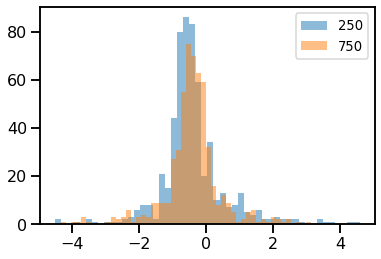

In [8]:
def adp_in_area(df_filter):

    gb_R1 = df_filter[(df_filter.stim2_id == 0) & (df_filter.resp_id == 'R1')].groupby(['area', 'cell_id']).sum()['dfof'].values
    gb_R2 = df_filter[(df_filter.stim2_id == 0) & (df_filter.resp_id == 'R2')].groupby(['area', 'cell_id']).sum()['dfof'].values
    gb_adp = (gb_R2 - gb_R1) / (gb_R1 + 1e-7)
    gb_adp = gb_adp[np.abs(gb_adp) < 5]

    return gb_adp

df_filter = df_tidy#[df_tidy.isi == 250]
gb_adp_250 = adp_in_area(df_filter[df_filter.isi == 250])
gb_adp_750 = adp_in_area(df_filter[df_filter.isi == 750])

plt.hist(gb_adp_250, bins=50, alpha=.5, label='250')
plt.hist(gb_adp_750, bins=50, alpha=.5, label='750')
plt.legend();

# adp_mean_arr = [np.mean(gb_adp_V1), np.mean(gb_adp_LM), np.mean(gb_adp_LI)]
# adp_med_arr = [np.median(gb_adp_V1), np.median(gb_adp_LM), np.median(gb_adp_LI)]
# adp_sem_arr = [np.std(gb_adp_V1) / np.sqrt(len(gb_adp_V1)), 
#                np.std(gb_adp_LM) / np.sqrt(len(gb_adp_LM)),
#                 np.std(gb_adp_LI) / np.sqrt(len(gb_adp_LI))]
# plt.errorbar([1, 2, 3], adp_mean_arr, yerr=adp_sem_arr, label='mean', alpha=.5)
# plt.errorbar([1, 2, 3], adp_med_arr, yerr=adp_sem_arr, label='median', alpha=.5)
# plt.xticks([1, 2, 3], ['V1', 'LM', 'LI']);
# plt.ylim([-1, 0]);
# plt.legend(frameon=False);

# sns.boxplot(data=[gb_adp_250, gb_adp_750], palette='Set2', notch=True, showfliers=False) # dont show the outliers beyond the caps
# plt.xticks([0, 1], ['250', '750']);
# plt.ylabel('adaptation index');
# sns.despine();

dir_fig = r'C:\Users\ll357\Documents\inter\results\tuning bias'.replace('\\', '/')
# plt.savefig(os.path.join(dir_fig, 'adp_grat8_by_area.pdf'))

## save & reload

In [10]:
dir_df = r'\\duhs-user-nc1.dhe.duke.edu\dusom_glickfeldlab\All_Staff\home\lan\Data\2P_images\mat_inter\df tidy for plots/'.replace('\\', '/')
csv_filename = 'df_tidy_grat_8ori_3isi_miaomiao_jin.csv'

# chunks = np.array_split(df_tidy.index, 100) # split into 100 chunks
# for chunk, subset in enumerate(tqdm(chunks)):
#     if chunk == 0: # first row
#         df_tidy.loc[subset].to_csv(csv_filename, mode='w', index=True)
#     else:
#         df_tidy.loc[subset].to_csv(csv_filename, header=None, mode='a', index=True)

df_tidy = pd.read_csv(os.path.join(dir_df, csv_filename), index_col=0)

# df for tuning curve

In [11]:
df_tidy

,dfof,cell_id,trial_id,resp_id,isi,stim1_contrast,stim2_id,area,stim1_id,filter_cell_vis,filter_cell_stim,mouse,date,sess
0,0.123997,170324_674_0,0,R1,750,1,5,V1,0,True,False,674,170324,002-003
1,-0.020478,170324_674_0,1,R1,250,1,3,V1,0,True,False,674,170324,002-003
2,0.036473,170324_674_0,6,R1,250,1,5,V1,0,True,False,674,170324,002-003
3,-0.021505,170324_674_0,7,R1,750,1,3,V1,0,True,False,674,170324,002-003
4,0.018712,170324_674_0,9,R1,250,1,0,V1,0,True,False,674,170324,002-003
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
409445,-0.001696,170826_746_48,430,R2,250,1,4,V1,0,True,False,746,170826,002-003
409446,-0.023031,170826_746_48,431,R2,250,1,1,V1,0,True,False,746,170826,002-003
409447,-0.008022,170826_746_48,432,R2,750,1,2,V1,0,True,False,746,170826,002-003
409448,0.008595,170826_746_48,433,R2,250,1,7,V1,0,True,False,746,170826,002-003


In [12]:
df_tuning = df_tidy[['dfof', 'cell_id', 'resp_id', 'isi', 'stim2_id', 
                    'area', 'filter_cell_vis', 
                    # 'filter_cell_well_fit', 'filter_cell_well_fit_ad_250', 
                    # 'ori_pref_ad_250', 'ori_pref_noad', 
                    # 'pref_unadapted_distance', 'pref_unadapted_distance_bin', 'pref_adapted_distance', 
                    # 'tuning_bias', 'tuning_bias_control',
                    ]]
df_tuning = df_tuning[(df_tuning.isi > -1) # placeholder, always true
                    & (df_tuning.filter_cell_vis == True)
                    & ((df_tuning.isi == 250) | (df_tuning.isi == 6000))
                    ]
                    
df_tuning['tuning_noad'] = np.pi
df_tuning['tuning_250'] = np.pi

for icell in tqdm(df_tuning.cell_id.unique()):
    ## tuning curve when isi = 6000, no adapter
    tuning_noad = df_tuning.loc[(df_tuning.cell_id == icell) & (df_tuning.isi == 6000) & (df_tuning.resp_id == 'R2'), :].groupby(['stim2_id'], sort=True).agg(np.nanmean)['dfof'].values# groupby sort: sorted by key, aka stim2_id. take R2 of no adapter trials to get tuning curve when no adapter
    df_tuning.loc[(df_tuning.cell_id == icell), 'tuning_noad'] = df_tuning.loc[(df_tuning.cell_id == icell), 'tuning_noad'].apply(lambda x: tuning_noad)
    
    ## tuning curve when isi = 250
    tuning_250 = df_tuning.loc[(df_tuning.cell_id == icell) & (df_tuning.isi == 250) & (df_tuning.resp_id == 'R2'), :].groupby(['stim2_id'], sort=True).agg(np.nanmean)['dfof'].values
    df_tuning.loc[(df_tuning.cell_id == icell), 'tuning_250'] = df_tuning.loc[(df_tuning.cell_id == icell), 'tuning_250'].apply(lambda x: tuning_250)

df_tuning.sample(5, random_state=0)

100%|██████████| 482/482 [00:39<00:00, 12.12it/s]


,dfof,cell_id,resp_id,isi,stim2_id,area,filter_cell_vis,tuning_noad,tuning_250
355596,0.262515,170816_745_25,R2,6000,6,V1,True,"[0.06465830069530332, 0.07024384359223879, 0.0...","[0.005895489556718416, 0.05985420929606872, 0...."
97009,0.151056,170323_696_22,R2,6000,0,V1,True,"[0.037358763261636965, 0.012934330930654714, 0...","[0.01672618394299408, 0.014321049307267618, 0...."
107559,-0.058787,170323_696_48,R2,6000,1,V1,True,"[0.006725637630569131, 0.01842489243566174, 0....","[0.006200666599943769, 0.011817575997853614, 0..."
204457,0.129164,170510_574_45,R1,250,1,V1,True,"[0.37430977985382125, 0.3092807275032376, 0.31...","[0.011177160284064675, 0.034885655201533895, 0..."
363638,0.165652,170816_745_43,R2,6000,3,V1,True,"[0.09779181625472327, 0.1403293338584462, 0.14...","[0.07699930186329468, 0.1522313596053068, 0.15..."


## filter cell gOSI
for well fit cells, calculate global orientation selectivity index (gOSI)  
formula taken from [Causal importance of orientation selectivity for generalization in image recognition](https://openreview.net/pdf?id=Bkx_Dj09tQ)

In [13]:
for icell in tqdm(df_tuning.cell_id.unique()):
    df_cell = df_tuning[df_tuning.cell_id == icell]

    tuning_noad = df_cell.tuning_noad.values[0] - min(df_cell.tuning_noad.values[0]) # ensure all values are non negative
    tuning_250 = df_cell.tuning_250.values[0] - min(df_cell.tuning_250.values[0])

    theta_arr = np.linspace(0, 180-22.5, 8) # according to formula: unit deg, not rad
    sin_arr = np.sin(2 * theta_arr)
    cos_arr = np.cos(2 * theta_arr)

    gOSI_noad = np.sqrt((np.sum(tuning_noad * sin_arr))**2 + (np.sum(tuning_noad * cos_arr))**2) / np.sum(tuning_noad)
    gOSI_250 = np.sqrt((np.sum(tuning_250 * sin_arr))**2 + (np.sum(tuning_250 * cos_arr))**2) / np.sum(tuning_250)

    df_tuning.loc[df_tuning.cell_id == icell, 'gOSI_noad'] = gOSI_noad
    df_tuning.loc[df_tuning.cell_id == icell, 'gOSI_250'] = gOSI_250

df_tuning

100%|██████████| 482/482 [00:14<00:00, 33.81it/s]


,dfof,cell_id,resp_id,isi,stim2_id,area,filter_cell_vis,tuning_noad,tuning_250,gOSI_noad,gOSI_250
1,-0.020478,170324_674_0,R1,250,3,V1,True,"[-0.0013643157915699125, 0.005271318457939338,...","[0.008913068308823267, -0.021396008957600476, ...",0.324613,0.301693
2,0.036473,170324_674_0,R1,250,5,V1,True,"[-0.0013643157915699125, 0.005271318457939338,...","[0.008913068308823267, -0.021396008957600476, ...",0.324613,0.301693
4,0.018712,170324_674_0,R1,250,0,V1,True,"[-0.0013643157915699125, 0.005271318457939338,...","[0.008913068308823267, -0.021396008957600476, ...",0.324613,0.301693
5,0.094969,170324_674_0,R1,250,5,V1,True,"[-0.0013643157915699125, 0.005271318457939338,...","[0.008913068308823267, -0.021396008957600476, ...",0.324613,0.301693
6,0.043600,170324_674_0,R1,250,1,V1,True,"[-0.0013643157915699125, 0.005271318457939338,...","[0.008913068308823267, -0.021396008957600476, ...",0.324613,0.301693
...,...,...,...,...,...,...,...,...,...,...,...
409443,-0.037524,170826_746_48,R2,6000,6,V1,True,"[0.03889302421285534, 0.02247627182215986, 0.0...","[0.00019849356526639936, 0.04753583625073863, ...",0.382866,0.436267
409444,-0.089406,170826_746_48,R2,6000,0,V1,True,"[0.03889302421285534, 0.02247627182215986, 0.0...","[0.00019849356526639936, 0.04753583625073863, ...",0.382866,0.436267
409445,-0.001696,170826_746_48,R2,250,4,V1,True,"[0.03889302421285534, 0.02247627182215986, 0.0...","[0.00019849356526639936, 0.04753583625073863, ...",0.382866,0.436267
409446,-0.023031,170826_746_48,R2,250,1,V1,True,"[0.03889302421285534, 0.02247627182215986, 0.0...","[0.00019849356526639936, 0.04753583625073863, ...",0.382866,0.436267


In [16]:
df_tuning.groupby('area').gOSI_noad.describe() # df tuning is well-fit cells only. even so, LI gOSI is much worse than V1 and LM

,count,mean,std,min,25%,50%,75%,max
area,,,,,,,,
V1,198929.0,0.435225,0.172293,0.015039,0.307736,0.435505,0.556673,0.847809


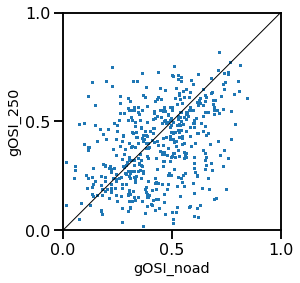

In [17]:
tmp1 = df_tuning.sort_values(by=['gOSI_noad', 'gOSI_250'], ascending=False).gOSI_noad.values
tmp2 = df_tuning.sort_values(by=['gOSI_noad', 'gOSI_250'], ascending=False).gOSI_250.values
# tmp3 = df_tuning.sort_values(by=['gOSI_noad', 'gOSI_250'], ascending=False).tuning_bias.values

plt.scatter(tmp1, tmp2, alpha=.1, s=1);
plt.plot([0, 1], [0, 1], color='k', linestyle='-', linewidth=1); # draw diagonal line

plt.xlim([0, 1]);
plt.ylim([0, 1]);
plt.xticks([0, .5, 1]);
plt.yticks([0, .5, 1]);
plt.xlabel('gOSI_noad');
plt.ylabel('gOSI_250');
plt.gca().set_aspect('equal', adjustable='box'); # set axis square

## gOSI noad is usually higher. gOSI noad vs 250 is correlated

## filter cell ori-mod
dont fit tuning curve, dont filter well fit cells.  
find orientation-modulated cells by anova across all orientations responses

In [18]:
cell_property = (df_tidy[['cell_id', 'isi', 'area', 'filter_cell_vis']] # need cell info: area, vis driven
                 .groupby(['cell_id', 'isi']) # prepare to match with df_ori_mod
                 .first() # only take first value. all values should be the same for each cell and isi combination
                 .reset_index())
cell_property

,cell_id,isi,area,filter_cell_vis
0,170323_689_0,250,V1,True
1,170323_689_0,750,V1,True
2,170323_689_0,6000,V1,True
3,170323_689_1,250,V1,False
4,170323_689_1,750,V1,False
...,...,...,...,...
1756,170826_746_8,750,V1,False
1757,170826_746_8,6000,V1,False
1758,170826_746_9,250,V1,True
1759,170826_746_9,750,V1,True


In [19]:
## construct tuning_vec column

df_ori_mod = (df_tidy[df_tidy.resp_id == 'R2'] # only R2 has diff ori
            [['dfof', 'cell_id', 'resp_id', 'isi', 'stim2_id']]
              .groupby(['cell_id', 'isi', 'stim2_id']).agg({'dfof': 'mean'}) # aggregate resp by cell, isi, ori
              .groupby(['cell_id', 'isi']).agg({'dfof':lambda x: list(x)}) # each row is a list of aggregated resp across ori
              .reset_index()
              .rename(columns={'dfof': 'tuning_vec'})
              .merge(cell_property, on=['cell_id', 'isi'], how='left') # merge with cell info
            )
df_ori_mod

,cell_id,isi,tuning_vec,area,filter_cell_vis
0,170323_689_0,250,"[0.0388499074107737, 0.028516304864018502, 0.0...",V1,True
1,170323_689_0,750,"[0.039857768164824586, 0.04167231509353064, 0....",V1,True
2,170323_689_0,6000,"[0.06338796165153944, 0.07376063577681458, 0.0...",V1,True
3,170323_689_1,250,"[-0.006239601434112747, 0.028367459482903187, ...",V1,False
4,170323_689_1,750,"[0.007579799649491357, 0.022330068866486825, -...",V1,False
...,...,...,...,...,...
1756,170826_746_8,750,"[0.06214298595549563, 0.029010662909225143, 0....",V1,False
1757,170826_746_8,6000,"[0.059667259379216624, 0.061716979140053745, 0...",V1,False
1758,170826_746_9,250,"[0.05575754865272174, 0.015433443446375945, 0....",V1,True
1759,170826_746_9,750,"[0.016734280333430957, 0.04087381565284569, 0....",V1,True


In [20]:
## construct ori_mod column

from scipy.stats import kruskal
p_threshold = 0.05

df_kruskal = (df_tidy[df_tidy.resp_id == 'R2'] # only R2 has diff ori
            [['dfof', 'cell_id', 'isi', 'stim2_id']]
            .groupby(['cell_id', 'isi', 'stim2_id']) # for each cell, each isi condition, calc responses to each ori
            .agg({'dfof':lambda x: list(x)}) # each row, dfof col contains a list of ori responses across trials
            .reset_index()
            .groupby(['cell_id', 'isi']) # for each cell, each isi condition, calc ori modulation
            .apply(lambda x: kruskal(*x.dfof.values).pvalue < p_threshold) # kruskal, where each ori is a group
            .reset_index()
            )
df_kruskal = df_kruskal.rename(columns={0: 'ori_mod'}) # bool col for ori modulation

df_ori_mod = df_ori_mod.merge(df_kruskal, on=['cell_id', 'isi'], how='left')
df_ori_mod

,cell_id,isi,tuning_vec,area,filter_cell_vis,ori_mod
0,170323_689_0,250,"[0.0388499074107737, 0.028516304864018502, 0.0...",V1,True,False
1,170323_689_0,750,"[0.039857768164824586, 0.04167231509353064, 0....",V1,True,False
2,170323_689_0,6000,"[0.06338796165153944, 0.07376063577681458, 0.0...",V1,True,False
3,170323_689_1,250,"[-0.006239601434112747, 0.028367459482903187, ...",V1,False,False
4,170323_689_1,750,"[0.007579799649491357, 0.022330068866486825, -...",V1,False,False
...,...,...,...,...,...,...
1756,170826_746_8,750,"[0.06214298595549563, 0.029010662909225143, 0....",V1,False,True
1757,170826_746_8,6000,"[0.059667259379216624, 0.061716979140053745, 0...",V1,False,False
1758,170826_746_9,250,"[0.05575754865272174, 0.015433443446375945, 0....",V1,True,False
1759,170826_746_9,750,"[0.016734280333430957, 0.04087381565284569, 0....",V1,True,False


In [21]:
## construct max_ori and max_ori_distance column

df_ori_mod['max_ori'] = df_ori_mod.tuning_vec.apply(lambda x: np.argmax(x)) # NOTE: even though we calculated max_ori for isi 250 and 750, only isi 6000 was actually used below (inherited by df_lineplot)
df_ori_mod['max_ori_dist'] = df_ori_mod.max_ori.apply(lambda x: 22.5*(8-x) if x > 4 else 22.5*x) # distance from 0 deg, hard coded for 8 ori. TODO: modify if needed

# df_ori_mod.groupby('max_ori').max_ori_distance.value_counts()
# df_ori_mod.groupby('max_ori_distance').max_ori.value_counts()
df_ori_mod.groupby('max_ori').max_ori_dist.unique()

max_ori
0     [0.0]
1    [22.5]
2    [45.0]
3    [67.5]
4    [90.0]
5    [67.5]
6    [45.0]
7    [22.5]
Name: max_ori_dist, dtype: object

In [22]:
## prepare for lineplot. don't need tuning vec, but need (stim2_id, dfof) observations
df_lineplot = (df_tidy[df_tidy.resp_id == 'R2'] # only R2 has diff ori
                      [['dfof', 'cell_id', 
                        'area', 'filter_cell_vis',
                        'resp_id', 'isi', 'stim2_id']]
                        .reset_index(drop=True)
                        )

## inherit ori_mod, max_ori, max_ori_distance from df_ori_mod
df_lineplot = df_lineplot.merge(
      df_ori_mod[df_ori_mod.isi == 6000]
      [['cell_id', 'ori_mod', 'max_ori', 'max_ori_dist', ]], 
      on=['cell_id'], how='left') # only use isi 6000 (no adapter condition) to determine ori_mod, max_ori and max_ori_dist for each cell

## inherit tuning_vec from df_ori_mod, for each isi
df_lineplot = df_lineplot.merge(
      df_ori_mod
      [['cell_id', 'tuning_vec', 'isi']],
      on=['cell_id', 'isi'], how='left') # take tuning_vec from df_ori_mod, for each cell and isi
df_lineplot

,dfof,cell_id,area,filter_cell_vis,resp_id,isi,stim2_id,ori_mod,max_ori,max_ori_dist,tuning_vec
0,0.614854,170324_674_0,V1,True,R2,750,5,True,5,67.5,"[-0.003747857892641345, 0.02574579909775683, 0..."
1,0.099134,170324_674_0,V1,True,R2,250,3,True,5,67.5,"[0.008913068308823267, -0.021396008957600476, ..."
2,0.013130,170324_674_0,V1,True,R2,6000,6,True,5,67.5,"[-0.0013643157915699125, 0.005271318457939338,..."
3,0.072787,170324_674_0,V1,True,R2,6000,6,True,5,67.5,"[-0.0013643157915699125, 0.005271318457939338,..."
4,0.224765,170324_674_0,V1,True,R2,6000,7,True,5,67.5,"[-0.0013643157915699125, 0.005271318457939338,..."
...,...,...,...,...,...,...,...,...,...,...,...
240885,-0.001696,170826_746_48,V1,True,R2,250,4,False,0,0.0,"[0.00019849356526639936, 0.04753583625073863, ..."
240886,-0.023031,170826_746_48,V1,True,R2,250,1,False,0,0.0,"[0.00019849356526639936, 0.04753583625073863, ..."
240887,-0.008022,170826_746_48,V1,True,R2,750,2,False,0,0.0,"[0.0550250135607704, 0.04056128350911568, 0.00..."
240888,0.008595,170826_746_48,V1,True,R2,250,7,False,0,0.0,"[0.00019849356526639936, 0.04753583625073863, ..."


# tuning curve bias
no fitting, just align max response ori

In [23]:
df_lineplot['date'] = df_lineplot.cell_id.apply(lambda x: x.split('_')[0])
df_lineplot['mouse'] = df_lineplot.cell_id.apply(lambda x: x.split('_')[1])
df_lineplot.groupby(['mouse', 'date']).first()

,,dfof,cell_id,area,filter_cell_vis,resp_id,isi,stim2_id,ori_mod,max_ori,max_ori_dist,tuning_vec
mouse,date,,,,,,,,,,,
574,170510,0.131212,170510_574_0,V1,True,R2,6000,0,True,0,0.0,"[0.18862490188778855, 0.041200932102048414, 0...."
674,170324,0.614854,170324_674_0,V1,True,R2,750,5,True,5,67.5,"[-0.003747857892641345, 0.02574579909775683, 0..."
684,170327,0.028394,170327_684_0,V1,True,R2,250,2,True,3,67.5,"[0.019927489663447748, -0.010044398545693509, ..."
689,170323,-0.082712,170323_689_0,V1,True,R2,6000,6,False,1,22.5,"[0.06338796165153944, 0.07376063577681458, 0.0..."
696,170323,0.189413,170323_696_0,V1,True,R2,250,4,True,4,90.0,"[0.005663508577033684, 0.03958367714538963, 0...."
711,170503,0.300462,170503_711_0,V1,True,R2,250,0,False,2,45.0,"[0.14190278123707906, 0.1924860070445827, 0.23..."
712,170503,0.074088,170503_712_0,V1,True,R2,750,3,True,4,90.0,"[0.04122935161622047, 0.03072902527973208, 0.0..."
720,170808,0.158905,170808_720_0,V1,True,R2,750,1,False,6,45.0,"[0.018412556834434532, 0.02603197807957034, 0...."
738,170810,0.072577,170810_738_0,V1,True,R2,750,5,True,7,22.5,"[0.08295553143907179, 0.03234847614370117, 0.0..."


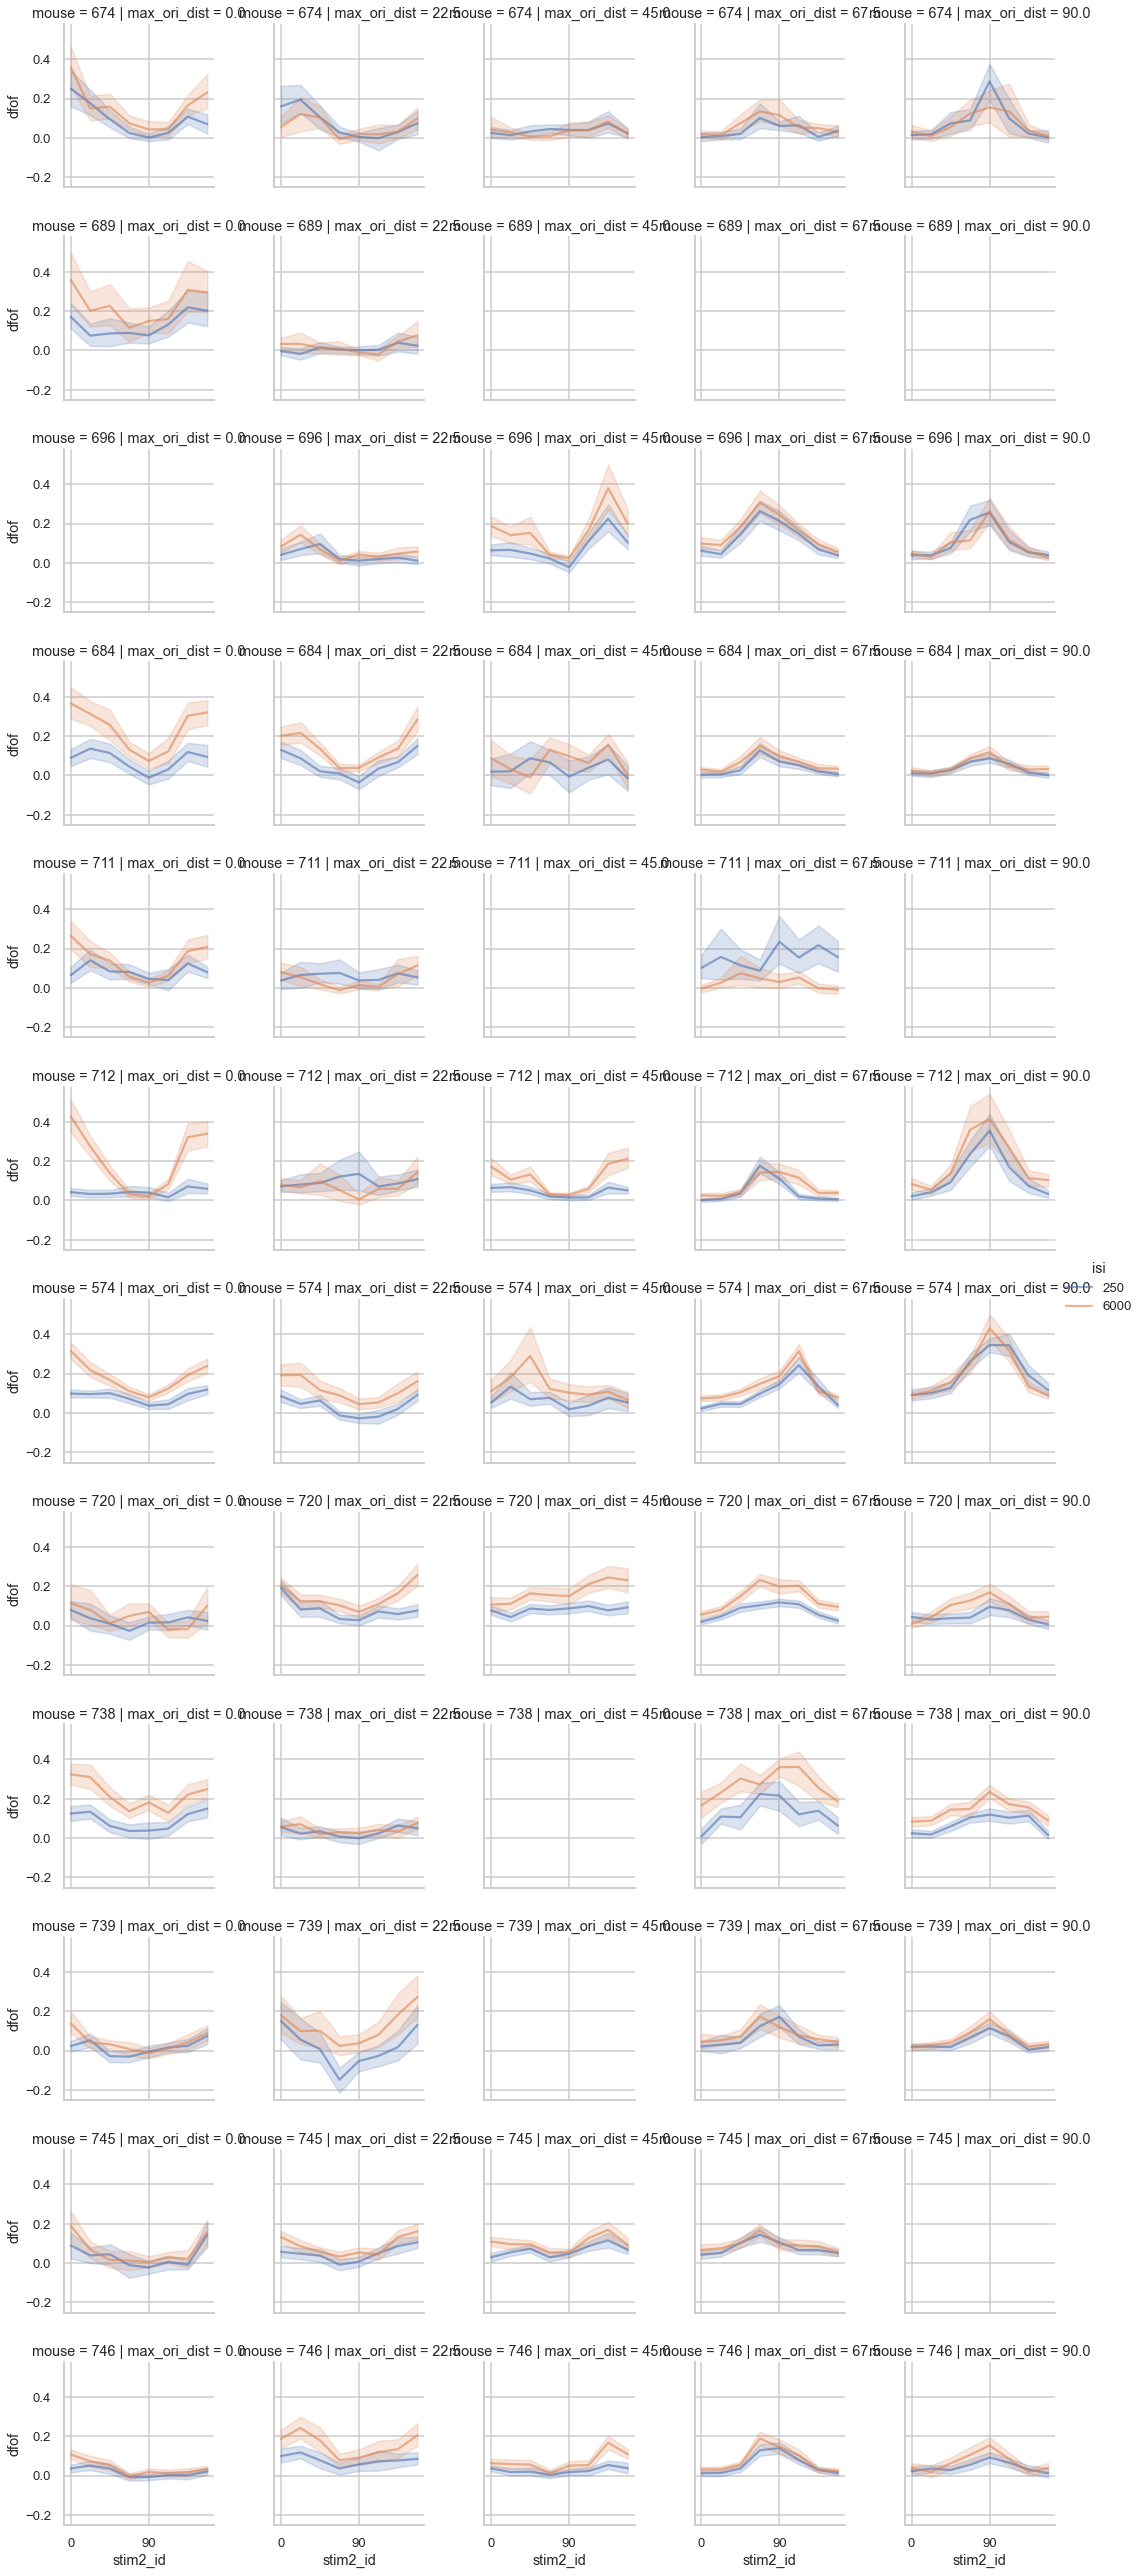

In [24]:
df_filter = df_lineplot[(df_lineplot.area == 'V1') # check V1 only
                       & (df_lineplot.isi != 750)
                       & (df_lineplot.ori_mod == True)
                       & (df_lineplot.filter_cell_vis == True)
                       ]

sns.set(font_scale=0.8, context='talk', style='whitegrid')
# g = sns.FacetGrid(df_filter, col="area", row="max_ori_dist", hue="isi")
g = sns.FacetGrid(df_filter, col="max_ori_dist", row="mouse", hue="isi") # which date has the most outrageous adp at orthogonal ori relative to adapter ori
g.map_dataframe(sns.lineplot, x="stim2_id", y="dfof", alpha=0.6)
g.figure.subplots_adjust(wspace=0.4, hspace=0.3)
g.add_legend();

# set xticks to 0, 4
for ax in g.axes.flat:
    ax.set_xticks([0, 4])
    ax.set_xticklabels(['0', '90'])

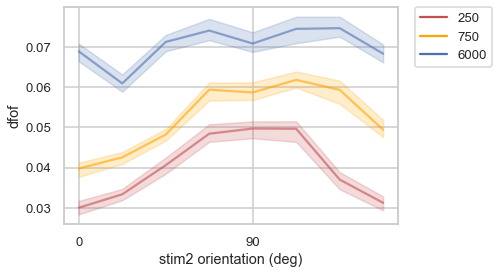

In [30]:
df_filter = df_lineplot[(df_lineplot.area == 'V1') # check V1 only
                       & (df_lineplot.ori_mod == True)
                       & (df_lineplot.filter_cell_vis == True)
                       ]

sns.lineplot(data=df_filter, x='stim2_id', y='dfof', hue='isi', ci=68, alpha=0.6, 
            estimator=np.median, 
            palette=['r', 'orange', 'b'],)
plt.xticks([0, 4], ['0', '90'])
plt.xlabel('stim2 orientation (deg)')
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.);

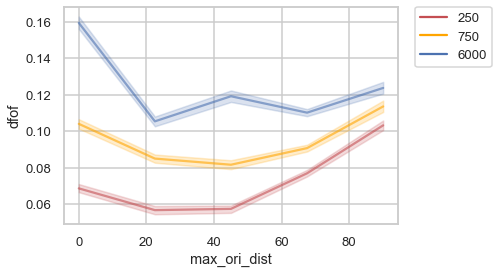

In [26]:
sns.lineplot(data=df_filter, x='max_ori_dist', y='dfof', hue='isi', ci=68, alpha=0.6, 
            estimator=np.mean, 
            palette=['r', 'orange', 'b'],)
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.);

In [129]:
## construct df for tuning_diff lineplot:
## for each cell_id, subtract tuning_vec of isi 250 by tuning_vec of isi 6000
tmp = df_lineplot.groupby(['cell_id', 'isi']).tuning_vec.first().to_frame()
tmp.head(6)

tmp_noad_shift = tmp.copy()
tmp_noad_shift['tuning_vec'] = tmp_noad_shift.tuning_vec.apply(lambda x: [min(x) for i in range(len(x))])
tmp_noad_shift.head(6)

tmp_noad_shift = (tmp_noad_shift.groupby(level=['cell_id']).transform('last')) # last isi is 6000
epsilon = 0.001
tmp_noad_shift.tuning_vec = tmp_noad_shift.tuning_vec.apply(lambda x: [-min(0, i) + epsilon for i in x])
tmp_noad_shift.head(6)

## split tuning_vec into 8 columns
tmp = tmp.tuning_vec.apply(pd.Series)
tmp.head(6)
# plt.hist(tmp.values.flatten(), bins=100);
# min(tmp.values.flatten()), max(tmp.values.flatten())

tmp_noad_shift = tmp_noad_shift.tuning_vec.apply(pd.Series)
tmp_noad_shift.head(6)

tmp = tmp + tmp_noad_shift # shift tuning_vec of all isi by min(tuning_vec) of isi 6000
tmp.head(6)

tmp_noad = (tmp.groupby(level=['cell_id']).transform('last'))
tmp_noad.head(6)

result = tmp / tmp_noad
result
# plt.hist(result.values.flatten(), bins=100);
# min(result.values.flatten()), max(result.values.flatten())

thresh = 5
result = result.applymap(lambda x: x if abs(x) < thresh else np.nan) # threshold too large values - change to nan
result

## merge 8 columns back to tuning_vec
result['tuning_diff']= result.values.tolist()
result

## merge tuning_diff back to df_lineplot
df_lineplot = df_lineplot.loc[:, df_lineplot.columns != 'tuning_diff'].merge( # prevent duplicate column
        result.loc[:, 'tuning_diff'].reset_index(), # NOTE tuning_diff is (tuning_ad250 - tuning_noad)
        on=['cell_id', 'isi'], how='left')
df_lineplot

,dfof,cell_id,area,filter_cell_vis,resp_id,isi,stim2_id,ori_mod,max_ori,max_ori_dist,tuning_vec,date,mouse,tuning_diff
0,0.614854,170324_674_0,V1,True,R2,750,5,True,5,67.5,"[-0.003747857892641345, 0.02574579909775683, 0...",170324,674,"[-1.3835421010714322, 3.681438105961323, 0.688..."
1,0.099134,170324_674_0,V1,True,R2,250,3,True,5,67.5,"[0.008913068308823267, -0.021396008957600476, ...",170324,674,"[nan, -2.4924836030816624, 0.8806995314266794,..."
2,0.013130,170324_674_0,V1,True,R2,6000,6,True,5,67.5,"[-0.0013643157915699125, 0.005271318457939338,...",170324,674,"[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]"
3,0.072787,170324_674_0,V1,True,R2,6000,6,True,5,67.5,"[-0.0013643157915699125, 0.005271318457939338,...",170324,674,"[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]"
4,0.224765,170324_674_0,V1,True,R2,6000,7,True,5,67.5,"[-0.0013643157915699125, 0.005271318457939338,...",170324,674,"[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]"
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
240885,-0.001696,170826_746_48,V1,True,R2,250,4,False,0,0.0,"[0.00019849356526639936, 0.04753583625073863, ...",170826,746,"[0.20053660570821583, 1.7835061779204355, 1.02..."
240886,-0.023031,170826_746_48,V1,True,R2,250,1,False,0,0.0,"[0.00019849356526639936, 0.04753583625073863, ...",170826,746,"[0.20053660570821583, 1.7835061779204355, 1.02..."
240887,-0.008022,170826_746_48,V1,True,R2,750,2,False,0,0.0,"[0.0550250135607704, 0.04056128350911568, 0.00...",170826,746,"[1.3333012377956492, 1.5654415273209432, 1.653..."
240888,0.008595,170826_746_48,V1,True,R2,250,7,False,0,0.0,"[0.00019849356526639936, 0.04753583625073863, ...",170826,746,"[0.20053660570821583, 1.7835061779204355, 1.02..."


In [151]:
df_filter = df_lineplot[(df_lineplot.area == 'V1') # check V1 only
                       & (df_lineplot.ori_mod == True)
                       & (df_lineplot.filter_cell_vis == True)
                       ]
# df_filter

df_tuning_diff = df_filter.groupby(['cell_id', 'isi']).tuning_diff.first().to_frame()
df_tuning_diff = df_tuning_diff.tuning_diff.apply(pd.Series)

# rename columns by adding 'stim' to each column
df_tuning_diff = df_tuning_diff.rename(columns={i: 'stim' + str(i) for i in range(8)})
df_tuning_diff = df_tuning_diff.reset_index()
df_tuning_diff

# pivot table so stim is row
df_tuning_diff = df_tuning_diff.melt(id_vars=['cell_id', 'isi'], var_name='stim', value_name='tuning_diff')
df_tuning_diff

# for stim col, take only the last char
df_tuning_diff['stim'] = df_tuning_diff.stim.apply(lambda x: x[-1])
df_tuning_diff.stim = df_tuning_diff.stim.astype(int)
df_tuning_diff['ori_dist'] = df_tuning_diff.stim.apply(lambda x: 22.5*(8-x) if x > 4 else 22.5*x) # stim2 distance from 0 deg, hard coded for 8 ori. TODO: modify if needed. here, we dont align by max ori of cells (to group cells), instead we plot all cells
df_tuning_diff

## inherit max_ori from df_lineplot
df_tuning_diff = df_tuning_diff.merge(df_filter[['cell_id', 'isi', 'max_ori', 'max_ori_dist']], on=['cell_id', 'isi'], how='inner')
df_tuning_diff = df_tuning_diff.drop_duplicates() # TODO: why are there duplicates?
df_tuning_diff

,cell_id,isi,stim,tuning_diff,ori_dist,max_ori,max_ori_dist
0,170323_689_10,250,0,0.482093,0.0,0,0.0
156,170323_689_10,250,1,0.172271,22.5,0,0.0
312,170323_689_10,250,2,-0.302158,45.0,0,0.0
468,170323_689_10,250,3,2.193134,67.5,0,0.0
624,170323_689_10,250,4,0.899043,90.0,0,0.0
...,...,...,...,...,...,...,...
696423,170826_746_7,6000,3,1.000000,67.5,6,45.0
696556,170826_746_7,6000,4,1.000000,90.0,6,45.0
696689,170826_746_7,6000,5,1.000000,67.5,6,45.0
696822,170826_746_7,6000,6,1.000000,45.0,6,45.0


In [140]:
df_tuning_diff.cell_id.nunique() # how many cells

216

In [159]:
## map with dict
ori_dist_bin = {0:0, 
                22.5:45,
                45:45,
                67.5:90,
                90:90,}

df_tuning_diff['ori_dist_bin'] = df_tuning_diff.ori_dist.map(ori_dist_bin)
df_tuning_diff['max_ori_dist_bin'] = df_tuning_diff.max_ori_dist.map(ori_dist_bin)

df_tuning_diff

,cell_id,isi,stim,tuning_diff,ori_dist,max_ori,max_ori_dist,ori_dist_bin,max_ori_dist_bin
0,170323_689_10,250,0,0.482093,0.0,0,0.0,0,0
156,170323_689_10,250,1,0.172271,22.5,0,0.0,45,0
312,170323_689_10,250,2,-0.302158,45.0,0,0.0,45,0
468,170323_689_10,250,3,2.193134,67.5,0,0.0,90,0
624,170323_689_10,250,4,0.899043,90.0,0,0.0,90,0
...,...,...,...,...,...,...,...,...,...
696423,170826_746_7,6000,3,1.000000,67.5,6,45.0,90,45
696556,170826_746_7,6000,4,1.000000,90.0,6,45.0,90,45
696689,170826_746_7,6000,5,1.000000,67.5,6,45.0,90,45
696822,170826_746_7,6000,6,1.000000,45.0,6,45.0,45,45


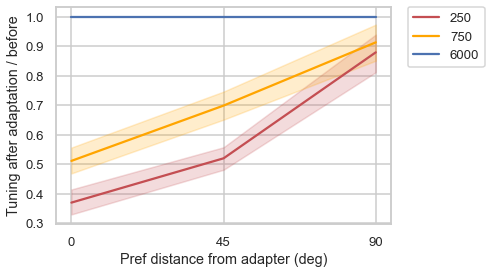

In [186]:
tmp = df_tuning_diff[df_tuning_diff.max_ori == df_tuning_diff.stim] # only take rows with max ori = stim2 ori
tmp

sns.lineplot(data=tmp, x='max_ori_dist_bin', y='tuning_diff', hue='isi', ci=68, #alpha=0.9,
            # estimator=np.median, 
            palette=['r', 'orange', 'b'],
            )

# set xticks 0, 45, 90
plt.xticks([0, 45, 90], [0, 45, 90])

plt.xlabel('Pref distance from adapter (deg)')
plt.ylabel('Tuning after adaptation / before')
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.);

# dir_fig = r'C:\Users\ll357\Documents\inter\results\tuning curve bias san check/'.replace('\\', '/')
# plt.savefig(dir_fig + 'Fig2E Jin2019.pdf', bbox_inches='tight')

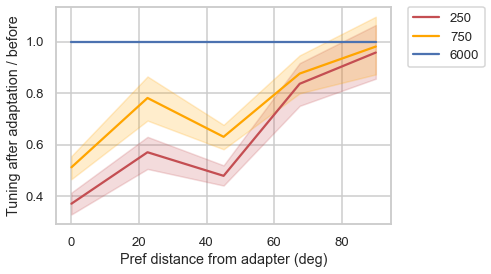

In [187]:
sns.lineplot(data=tmp, x='max_ori_dist', y='tuning_diff', hue='isi', ci=68, #alpha=0.9,
            # estimator=np.median, 
            palette=['r', 'orange', 'b'],
            )
plt.xlabel('Pref distance from adapter (deg)')
plt.ylabel('Tuning after adaptation / before')
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.);

# dir_fig = r'C:\Users\ll357\Documents\inter\results\tuning curve bias san check/'.replace('\\', '/')
# plt.savefig(dir_fig + 'tuning_diff_lineplot_binned.pdf', bbox_inches='tight')

In [184]:
tmp[(tmp.max_ori_dist == 45) & (tmp.isi == 250)].cell_id.nunique()

38

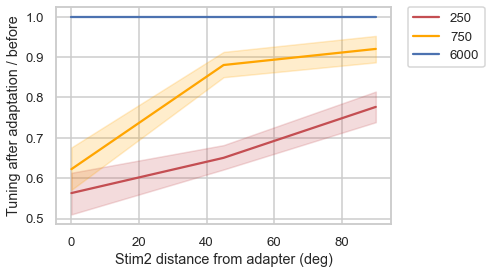

In [169]:
sns.lineplot(data=df_tuning_diff, x='ori_dist_bin', y='tuning_diff', hue='isi', ci=68, #alpha=0.9,
            # estimator=np.median, 
            palette=['r', 'orange', 'b'],
            )
plt.xlabel('Stim2 distance from adapter (deg)')
plt.ylabel('Tuning after adaptation / before')
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.);

dir_fig = r'C:\Users\ll357\Documents\inter\results\tuning curve bias san check/'.replace('\\', '/')
plt.savefig(dir_fig + 'tuning vs stim2_binned-adapter dist.pdf', bbox_inches='tight')

In [181]:
df_tuning_diff_shift = df_tuning_diff.copy()
df_tuning_diff_shift.tuning_diff = df_tuning_diff_shift.tuning_diff.apply(lambda x: x-1)

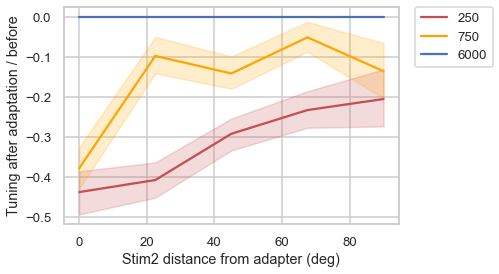

In [182]:
## set sns color palette
sns.lineplot(data=df_tuning_diff_shift, x='ori_dist', y='tuning_diff', hue='isi', ci=68, #alpha=0.9,
            # estimator=np.median, 
            palette=['r', 'orange', 'b'],
            )
plt.xlabel('Stim2 distance from adapter (deg)')
plt.ylabel('Tuning after adaptation / before')
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.);

dir_fig = r'C:\Users\ll357\Documents\inter\results\tuning curve bias san check/'.replace('\\', '/')
# plt.savefig(dir_fig + 'tuning vs stim2-adapter dist.pdf', bbox_inches='tight')
plt.savefig(dir_fig + 'Fig2D Jin2019.pdf', bbox_inches='tight')

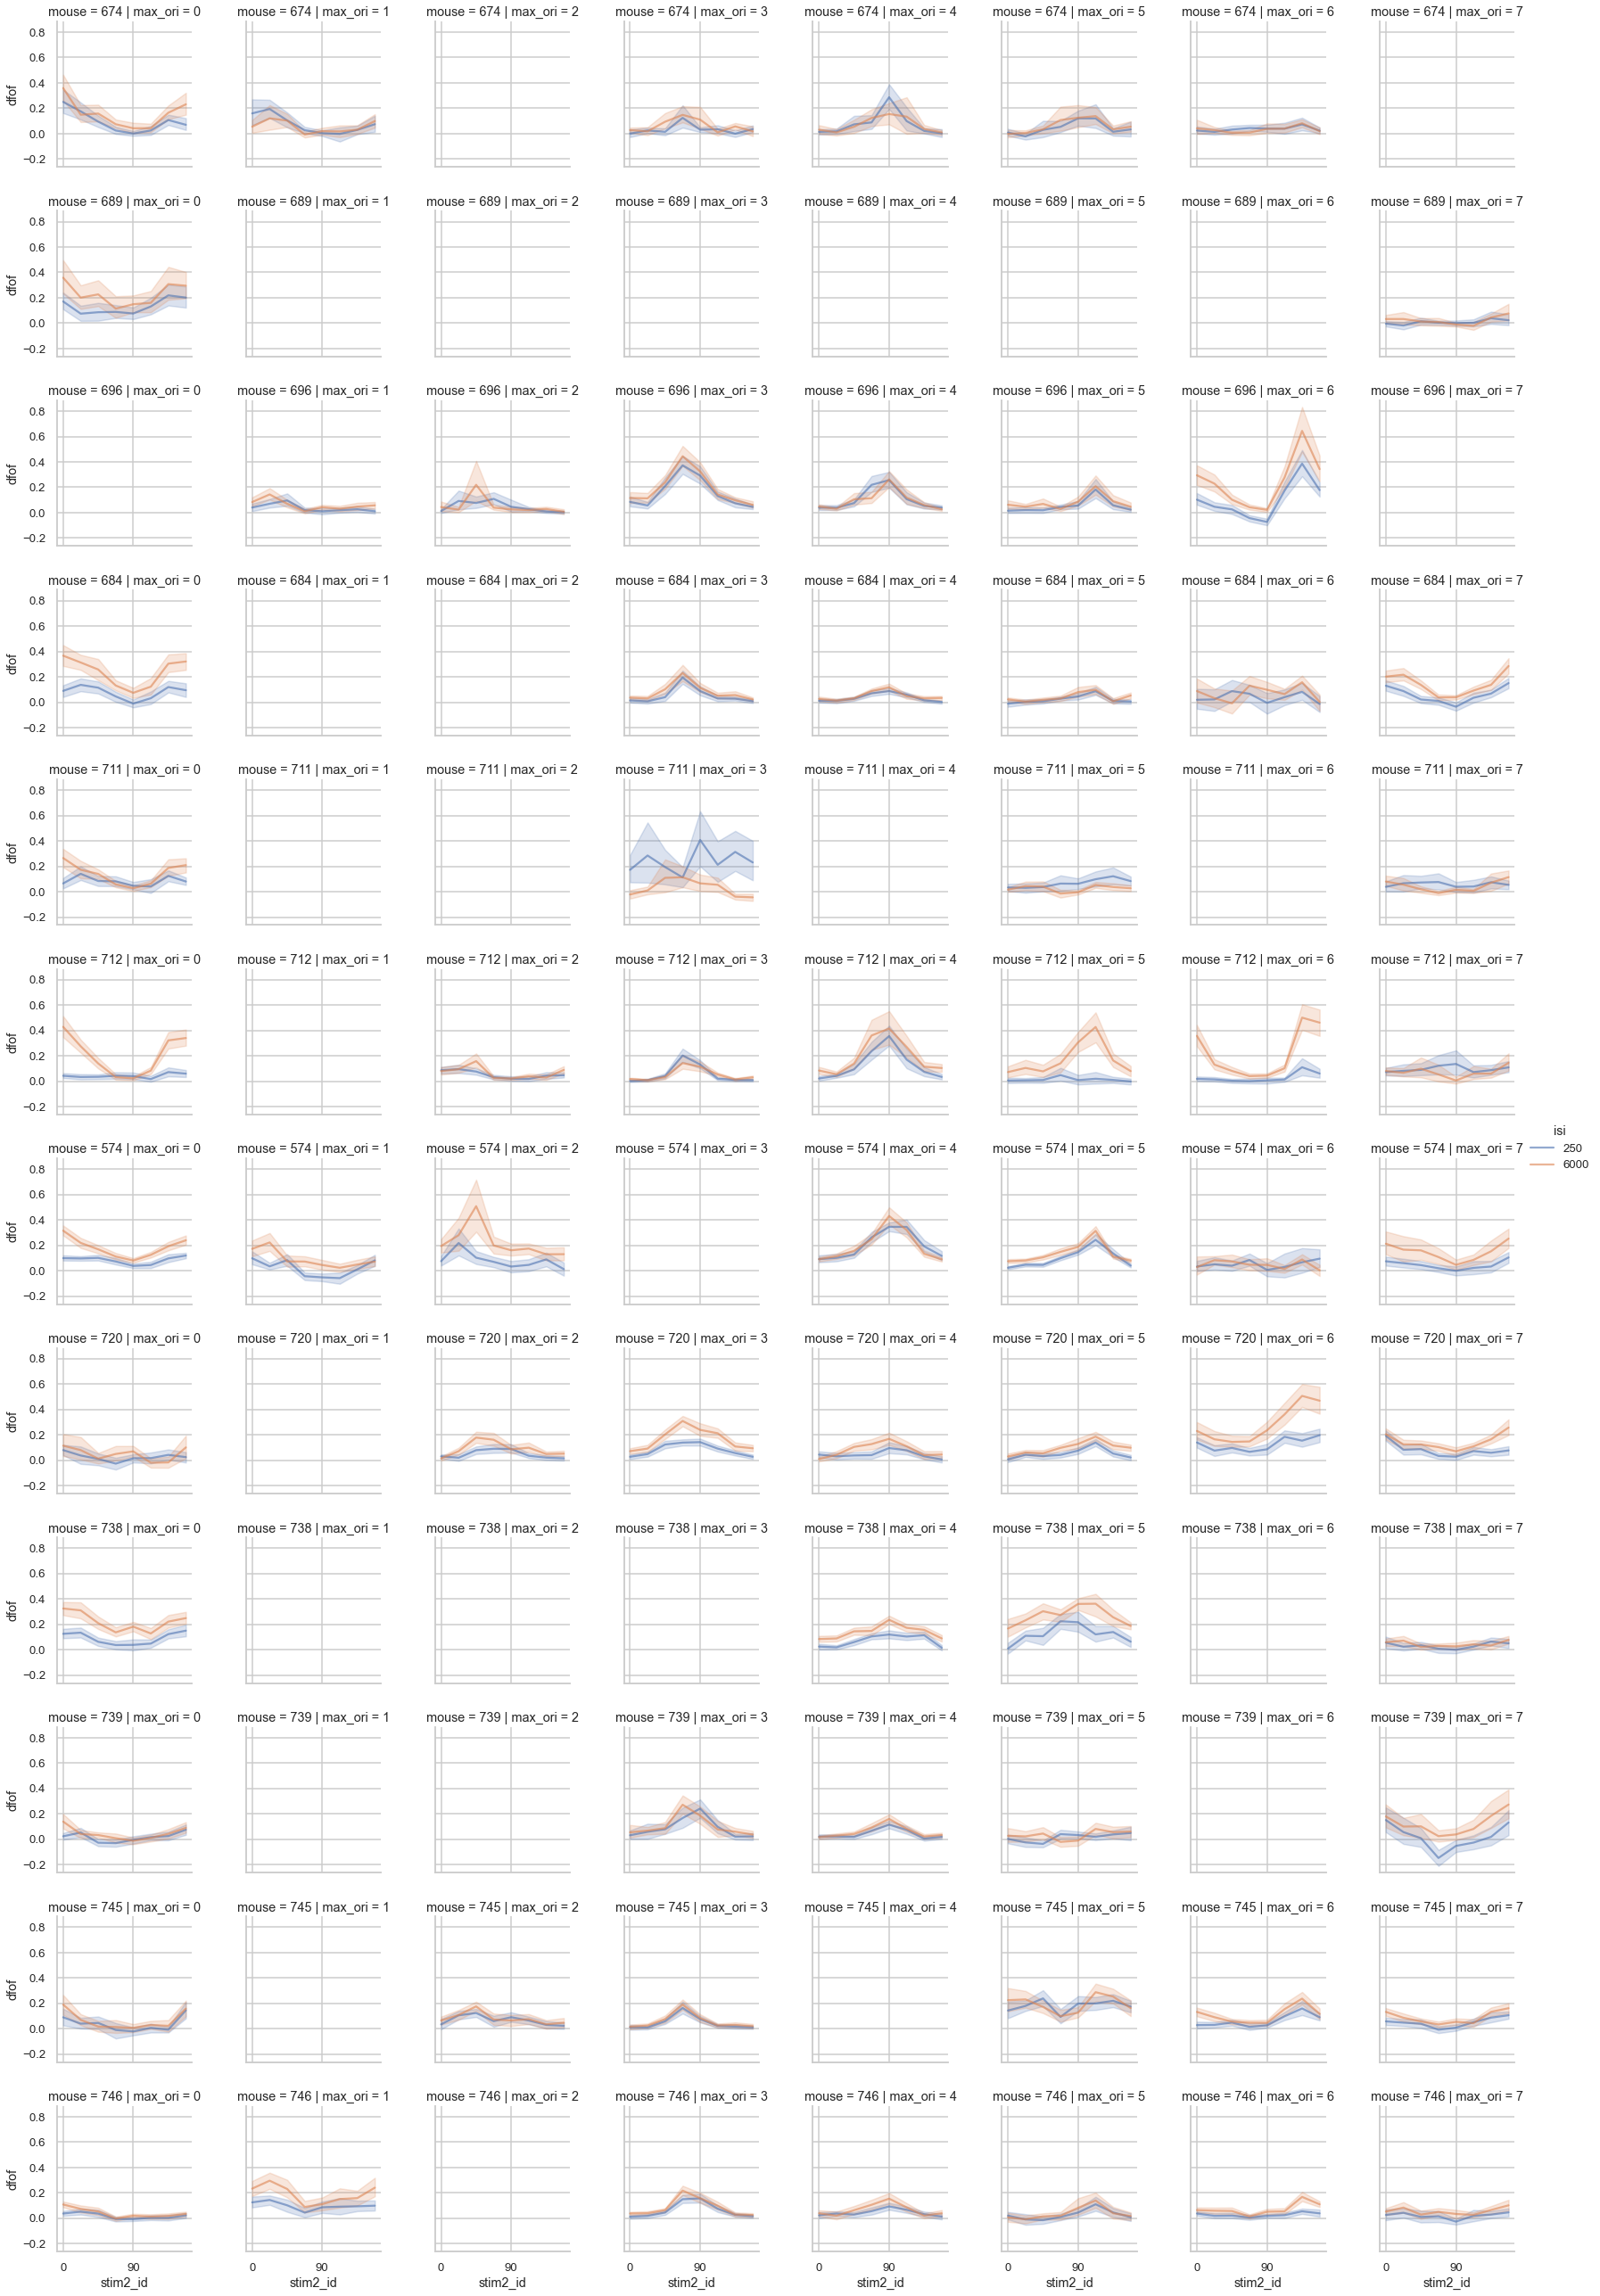

In [63]:
sns.set(font_scale=0.8, context='talk', style='whitegrid')
# g = sns.FacetGrid(df_filter, col="area", row="max_ori", hue="isi")
g = sns.FacetGrid(df_filter, col="max_ori", row="mouse", hue="isi")
g.map_dataframe(sns.lineplot, x="stim2_id", y="dfof", alpha=0.6)
g.figure.subplots_adjust(wspace=0.4, hspace=0.3)
g.add_legend();

for ax in g.axes.flat:
    ax.set_xticks([0, 4])
    ax.set_xticklabels(['0', '90'])